# Plan

As we discussed in EDA module, there are several ways to deal with seasonality:
1. Let the model learn on its own
2. Using lead-lag introduce some new variables by means of shifting yet letting the model learn on its own
3. Explicitly subtract seasonal components from predictor and. response and train model on residuals (technically bit more involved since `sklearn` API doesn't support transformations of response variable)

Here I will try all three using `GradientBoostingRegressor` from `sklearn`. The reason I'm choosing this estimator is it offers good flexibility and robustness paired with explainability. I can train one model for both cities (which if necessary will be incorporated via splitting by city). Plus it offers training with mean absolute error (MAE) objective function out of the box as opposed to linear models where the main term in the loss is L2 with potential L1 or L2 penalty (we could argue that it's acceptable to optimize with L2 and score with L1 but let's first use method that already optimizes L1).

The idea for training is to split available labeled data into `train` and `test`. Use train to `train` to train the model and choose hyperparameters by doing k-fold cross validation and use `test` as a final round to choose a model and validate generalization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
import importlib
import utils
importlib.reload(utils)

from utils import Data, Deseasoner, Seasonality, split_and_mix, get_scores, get_scores_from_loop

# Data & Parameters

Load data, fix randomness for the sake of reproducibility and reserve 80% of data for training and validation and 20% for true out of sample.

In [3]:
seed = 42
train_fraction = 0.8

data_manager = Data('data/dengue_features_train.csv', 'data/dengue_labels_train.csv')

n_splits = 7
cv = KFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=seed
)

param_grid = {
    'model__max_depth': [1, 2, 3, 5, 7, 9, 11, 13],
    'model__learning_rate': [1e-3, 1e-2, 1e-1, 1e0],
}

# 1. Const Model

But before we start using complex tools it's important to establish a benchmark. Here it makes sense to consider a simple model that just returns a median (we have some large deviations in `total_cases` so not mean).

In [4]:
data = data_manager.get_xy()

s = split_and_mix(data, train_fraction)
df_train = s['df_train']
df_test = s['df_test']

df = df_train
x = df[[c for c in df.columns if c != 'total_cases']]
y = df['total_cases']

score = []
for train_index, test_index in cv.split(x):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]

    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]

    y_pred = np.rint(y_train.median()) + 0 * y_test
    score.append(mean_absolute_error(y_pred, y_test))

print(f'MAE = {np.mean(score):0.4f}')

MAE = 21.1996


# 2. Seasonal Component Only

Second benchmark is just a seasonal component

In [5]:
data = data_manager.get_xy()

s = split_and_mix(data, train_fraction)
df_train = s['df_train']
df_test = s['df_test']

df = df_train
x = df[[c for c in df.columns if c != 'total_cases']]
y = df['total_cases']

deseasoner = Deseasoner(cols=data_manager.get_climate_and_target_cols())

score = []
for train_index, test_index in cv.split(x):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]

    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]

    deseasoner.fit(x_train, y_train)
    x_train_t, y_train_t = deseasoner.transform(x_train, y_train)
    x_test_t, y_test_t = deseasoner.transform(x_test, y_test)

    y_comp = deseasoner.get_component(pd.concat([x_test, y_test], axis=1))
    y_pred = np.rint(y_comp)
score.append(mean_absolute_error(y_pred, y_test))
print(f'MAE = {np.mean(score):0.4f}')

MAE = 19.9880


We see that the seasonal component is an improvement on the const model

# 3. Let the Model Learn

Best MAE = 14.7421
Best learning rate = 0.1
Best max_depth = 7


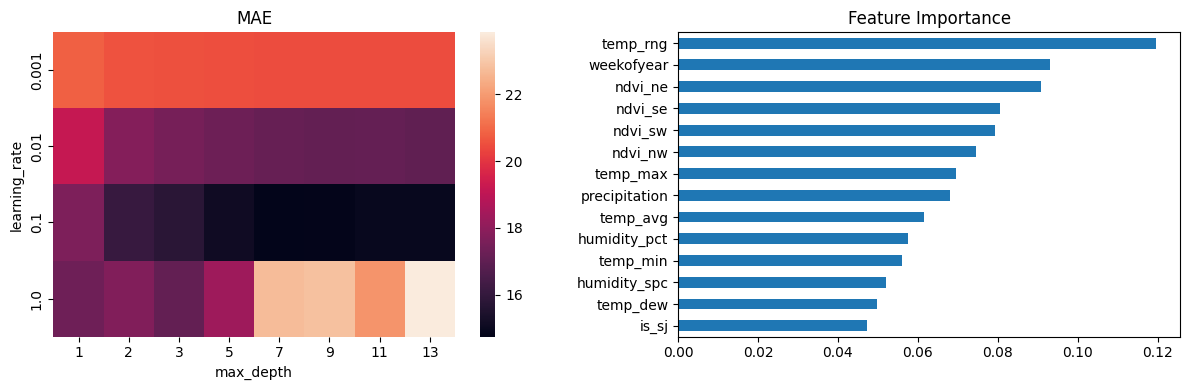

CPU times: user 2.18 s, sys: 598 ms, total: 2.78 s
Wall time: 22.7 s


In [6]:
%%time

data = data_manager.get_xy()

s = split_and_mix(data, train_fraction)
df_train = s['df_train']
df_test = s['df_test']

df = df_train
x = df[[c for c in df.columns if c != 'total_cases']]
y = df['total_cases']

model = GradientBoostingRegressor(
    loss='absolute_error',
    random_state=seed
)
pipe = Pipeline(steps=[('model', model)])
search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=cv,
    scoring='neg_mean_absolute_error'
)

search.fit(x, y)

mae = get_scores(search)
best_learning_rate, best_max_depth = mae.index[mae.argmin()]
print(f'Best MAE = {mae.min():0.4f}\nBest learning rate = {best_learning_rate}\nBest max_depth = {best_max_depth}')

best_model = search.best_estimator_['model']
imp = pd.Series(
    best_model.feature_importances_,
    index=best_model.feature_names_in_
).sort_values()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(mae.unstack(), ax=ax[0])
ax[0].set_title('MAE')
imp.plot.barh(ax=ax[1])
fig.tight_layout(h_pad=0, w_pad=3)
ax[1].set_title('Feature Importance')
plt.show()

Temperature range is the top predictor, followed by `weekofyear` which means the model is aware of seasonality. Then we have vegetation index data.

# 4. Add New Features

Do the same but with shifted climate data

Best MAE = 14.7941
Best learning rate = 0.1
Best max_depth = 9


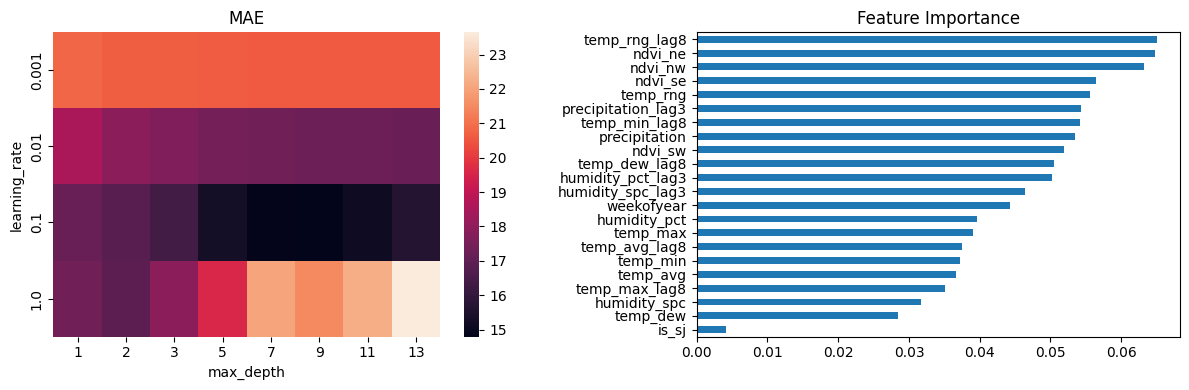

CPU times: user 2.65 s, sys: 210 ms, total: 2.86 s
Wall time: 27.9 s


In [7]:
%%time

data = data_manager.shift_and_get_xy()

s = split_and_mix(data, train_fraction)
df_train = s['df_train']
df_test = s['df_test']

df = df_train
x = df[[c for c in df.columns if c != 'total_cases']]
y = df['total_cases']

model = GradientBoostingRegressor(
    loss='absolute_error',
    random_state=seed
)
pipe = Pipeline(steps=[('model', model)])
search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=cv,
    scoring='neg_mean_absolute_error'
)

search.fit(x, y)

mae = get_scores(search)
best_learning_rate, best_max_depth = mae.index[mae.argmin()]
print(f'Best MAE = {mae.min():0.4f}\nBest learning rate = {best_learning_rate}\nBest max_depth = {best_max_depth}')

best_model = search.best_estimator_['model']
imp = pd.Series(
    best_model.feature_importances_,
    index=best_model.feature_names_in_
).sort_values()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(mae.unstack(), ax=ax[0])
ax[0].set_title('MAE')
imp.plot.barh(ax=ax[1])
fig.tight_layout(h_pad=0, w_pad=3)
ax[1].set_title('Feature Importance')
plt.show()

Shifted temperature range is the top predictor followed by vegetation index data. `weekofyear` is pushed down the list which means most of the seasonality effects are taken care of by shifting some features. But this model doesn’t beat the previous model with no shifts which probably means that contemporaneous data accumulates all necessary info.

# 5. Train on Residuals

Best MAE = 16.5240
Best learning rate = 0.1
Best max_depth = 5


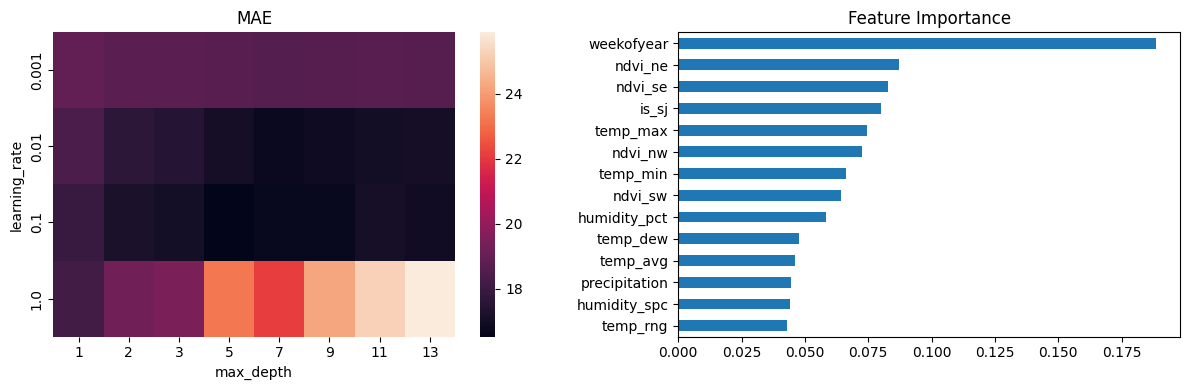

CPU times: user 2min 44s, sys: 327 ms, total: 2min 44s
Wall time: 2min 44s


In [8]:
%%time

data = data_manager.get_xy()

s = split_and_mix(data, train_fraction)
df_train = s['df_train']
df_test = s['df_test']

df = df_train
x = df[[c for c in df.columns if c != 'total_cases']]
y = df['total_cases']

deseasoner = Deseasoner(cols=data_manager.get_climate_and_target_cols())

score = {}
imps = {}
for learning_rate in param_grid['model__learning_rate']:
    score[learning_rate] = {}
    imps[learning_rate] = {}
    for max_depth in param_grid['model__max_depth']:
        score_arr = []
        for train_index, test_index in cv.split(x):
            x_train = x.iloc[train_index]
            y_train = y.iloc[train_index]

            x_test = x.iloc[test_index]
            y_test = y.iloc[test_index]

            deseasoner.fit(x_train, y_train)
            x_train_t, y_train_t = deseasoner.transform(x_train, y_train)
            x_test_t, y_test_t = deseasoner.transform(x_test, y_test)

            model = GradientBoostingRegressor(
                loss='absolute_error',
                max_depth=max_depth,
                learning_rate=learning_rate,
            )
            model.fit(x_train_t, y_train_t)
            
            y_pred_t = pd.Series(model.predict(x_test_t), index=x_test_t.index)
            y_comp = deseasoner.get_component(pd.concat([x_test, y_test], axis=1))
            y_pred = np.rint(y_pred_t + y_comp)
            score_arr.append(mean_absolute_error(y_pred, y_test))
        score[learning_rate][max_depth] = score_arr
        imps[learning_rate][max_depth] = model.feature_importances_

mae = get_scores_from_loop(score)
best_learning_rate, best_max_depth = mae.index[mae.argmin()]
print(f'Best MAE = {mae.min():0.4f}\nBest learning rate = {best_learning_rate}\nBest max_depth = {best_max_depth}')

imp = pd.Series(
    imps[best_learning_rate][best_max_depth],
    index=model.feature_names_in_
).sort_values()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(mae.unstack(), ax=ax[0])
ax[0].set_title('MAE')
imp.plot.barh(ax=ax[1])
fig.tight_layout(h_pad=0, w_pad=3)
ax[1].set_title('Feature Importance')
plt.show()

Surprisingly `weekofyear` is the top predictor. This probably means that we didn't fully eliminate seasonality. Alteration of vegetation indices and temperature data follow the lead.

# Best Model

We see model performance drop from 14.7421 to 16.6027 but staying consistent with train set level which doesn't look like overfit.

MAE = 8.0782


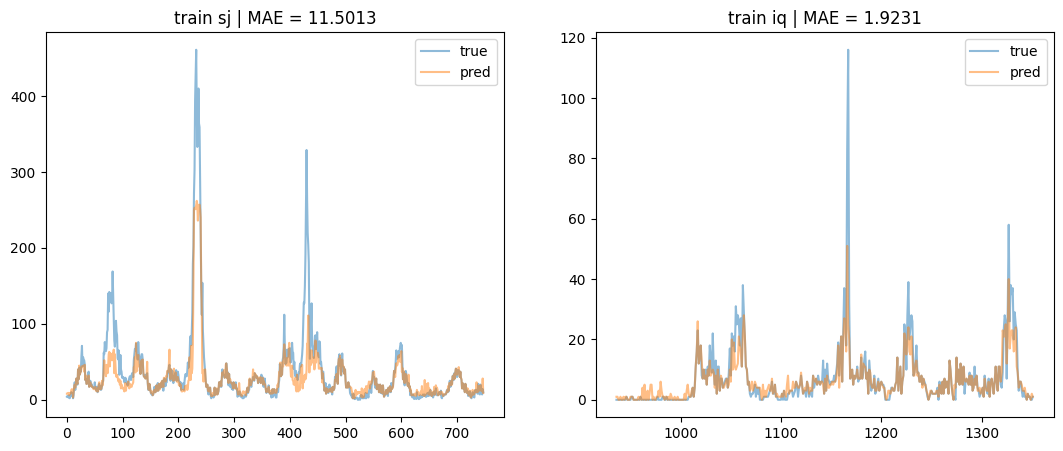

MAE = 16.6027


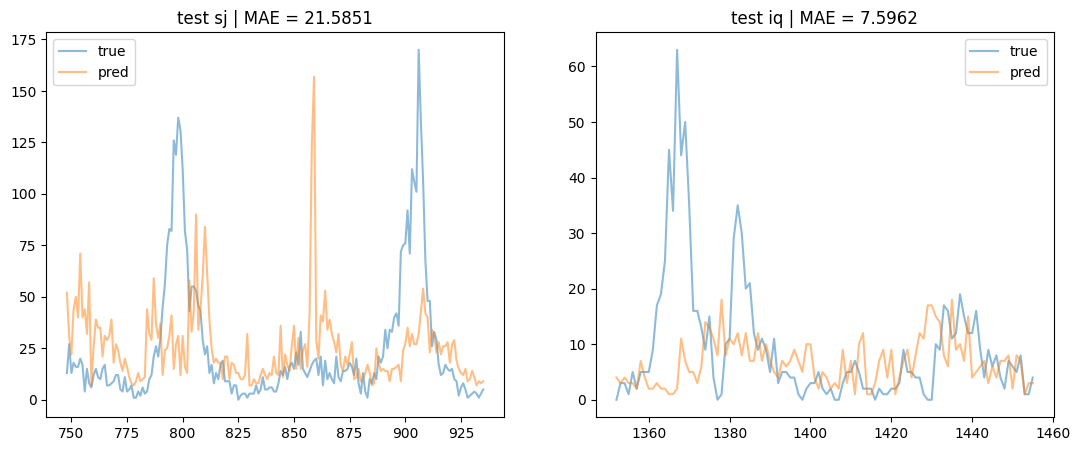

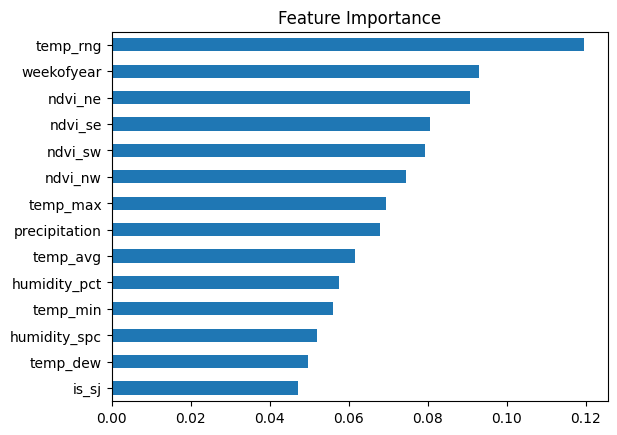

In [9]:
data = data_manager.get_xy()

s = split_and_mix(data, train_fraction)
df_train = s['df_train']
df_test = s['df_test']

x_train = s['x_train']
y_train = s['y_train']

x_test = s['x_test']
y_test = s['y_test']

model = GradientBoostingRegressor(
    loss='absolute_error',
    random_state=seed,
    learning_rate=0.1,
    max_depth=7
)
model.fit(x_train, y_train)

y_pred = np.rint(model.predict(x_train))
tmp = pd.DataFrame({
    'true': y_train,
    'pred': y_pred,
})
tmp_sj = tmp.loc[df_train[df_train.is_sj == 1].index]
tmp_iq = tmp.loc[df_train[df_train.is_sj == 0].index]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
tmp_sj.plot(alpha=0.5, title=f'train sj | MAE = {mean_absolute_error(tmp_sj.true, tmp_sj.pred):0.4f}', ax=ax[0])
tmp_iq.plot(alpha=0.5, title=f'train iq | MAE = {mean_absolute_error(tmp_iq.true, tmp_iq.pred):0.4f}', ax=ax[1])
print(f'MAE = {mean_absolute_error(tmp.true, tmp.pred):0.4f}')
plt.show()


y_pred = np.rint(model.predict(x_test))
tmp = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
})
tmp_sj = tmp.loc[df_test[df_test.is_sj == 1].index]
tmp_iq = tmp.loc[df_test[df_test.is_sj == 0].index]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
tmp_sj.plot(alpha=0.5, title=f'test sj | MAE = {mean_absolute_error(tmp_sj.true, tmp_sj.pred):0.4f}', ax=ax[0])
tmp_iq.plot(alpha=0.5, title=f'test iq | MAE = {mean_absolute_error(tmp_iq.true, tmp_iq.pred):0.4f}', ax=ax[1])
print(f'MAE = {mean_absolute_error(tmp.true, tmp.pred):0.4f}')
plt.show()

imp = pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_
).sort_values()
imp.plot.barh()
plt.title('Feature Importance')
plt.show()